# Imports

In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)

# Inladen opgeschoonde dataset

In [2]:
disruptions = pd.read_csv("clean.csv")
disruptions = disruptions.convert_dtypes()
disruptions.head()

,stm_prioriteit,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur
0,9,00:00:00,99999999.0,09:00:00,0
1,9,00:00:00,99999999.0,12:35:00,51
2,9,00:00:00,99999999.0,16:40:00,40
3,9,00:00:00,99999999.0,22:30:00,6
4,9,00:00:00,99999999.0,11:23:00,7


# Data understanding

Allereerst kijken we naar de numerieke variabelen, zodat we kunnen zien welke variabelen nog omgezet moeten worden tot een voor een model bruikbaar getal.

In [3]:
disruptions.describe()

,stm_prioriteit,stm_fh_duur
count,641460.000000,641548.000000
mean,4.464372,1015.514172
std,2.156160,6807.653478
min,1.000000,0.000000
25%,2.000000,13.000000
50%,4.000000,86.000000
75%,5.000000,269.000000
max,9.000000,528297.000000


We zien dat er nog drie variabelen zijn die nog verder moeten verwerkt.

Hierna kijken we ook nog naar de lege rijen, om te kijken in hoeverre deze data moet worden opgeschoond.

In [4]:
print(disruptions.isnull().sum().to_string())

stm_prioriteit        115
stm_aanntpl_tijd       27
stm_progfh_in_duur     27
stm_sap_meldtijd       27
stm_fh_duur            27


We zien dat er, percentueel gezien, weinig waarden ontbreken. Dit houdt in dat wij ze makkelijk kunnen laten vallen zonder dat het veel invloed op ons model zal hebben.

Hierna kijken we nog even naar de datatypes.

In [5]:
disruptions.dtypes

stm_prioriteit         Int64
stm_aanntpl_tijd      string
stm_progfh_in_duur    string
stm_sap_meldtijd      string
stm_fh_duur            Int64
dtype: object

En we zien hier dat "stm_aanntpl_tijd", "stm_progfh_in_duur" en "stm_sap_meldtijd" nog moeten worden omgezet tot numerieke waarden.

# Data cleanup

Hieronder worden de lege values opgevuld met prioriteit 9, dit omdat er ten eerste maar 112 values leeg zijn, en ten tweede omdat wij er vanuit gaan dat als de prioriteit niet is ingevuld, het geen belangrijk probleem is geweest. Daarna worden er dummy variabelen aangemaakt, zodat het model er mee kan werken.

In [6]:
disruptions['stm_prioriteit'] = disruptions['stm_prioriteit'].fillna(9)
disruptions['stm_prioriteit'] = disruptions['stm_prioriteit'].astype(str)
disruptions['stm_prioriteit'] = 'prio: ' + disruptions['stm_prioriteit'] 
dummies = pd.get_dummies(disruptions['stm_prioriteit'])
disruptions = disruptions.drop('stm_prioriteit', axis = 1)
disruptions = disruptions.join(dummies)
disruptions.head()

,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur,prio: 1,prio: 2,prio: 4,prio: 5,prio: 8,prio: 9
0,00:00:00,99999999.0,09:00:00,0,0,0,0,0,0,1
1,00:00:00,99999999.0,12:35:00,51,0,0,0,0,0,1
2,00:00:00,99999999.0,16:40:00,40,0,0,0,0,0,1
3,00:00:00,99999999.0,22:30:00,6,0,0,0,0,0,1
4,00:00:00,99999999.0,11:23:00,7,0,0,0,0,0,1


Hieronder word stm_fh_duur opgeschoond. Allereerst verwijderen we alles waarbij de duur 0 is, omdat we niet geïnteresseerd zijn in dit voorspellen, omdat de dienstregeling hierdoor niet verstoord wordt. Daarnaast verwijderen we ook alle storingen die langer dan een uur duren, omdat de opdrachtgever aangaf dat als een verstoring langer dan een dag duurt, de dienstregeling daar makkelijker op aan te passen is.

In [7]:
disruptions = disruptions[disruptions.stm_fh_duur != 0]
disruptions = disruptions[disruptions.stm_fh_duur < 1440]
disruptions.head()

,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur,prio: 1,prio: 2,prio: 4,prio: 5,prio: 8,prio: 9
1,00:00:00,99999999.0,12:35:00,51,0,0,0,0,0,1
2,00:00:00,99999999.0,16:40:00,40,0,0,0,0,0,1
3,00:00:00,99999999.0,22:30:00,6,0,0,0,0,0,1
4,00:00:00,99999999.0,11:23:00,7,0,0,0,0,0,1
5,00:00:00,99999999.0,23:25:00,13,0,0,0,0,0,1


Hieronder worden de dubbele punten tussen de tijdsstippen verwijderd, zodat het model er mee kan werken.

In [8]:
disruptions["stm_sap_meldtijd"] = disruptions["stm_sap_meldtijd"].str.replace(":", "")
disruptions = disruptions[disruptions.stm_sap_meldtijd != '']
disruptions["stm_sap_meldtijd"] = disruptions["stm_sap_meldtijd"].dropna()
disruptions["stm_sap_meldtijd"] = disruptions["stm_sap_meldtijd"].astype(int)
disruptions.head()

,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur,prio: 1,prio: 2,prio: 4,prio: 5,prio: 8,prio: 9
1,00:00:00,99999999.0,123500,51,0,0,0,0,0,1
2,00:00:00,99999999.0,164000,40,0,0,0,0,0,1
3,00:00:00,99999999.0,223000,6,0,0,0,0,0,1
4,00:00:00,99999999.0,112300,7,0,0,0,0,0,1
5,00:00:00,99999999.0,232500,13,0,0,0,0,0,1


In [9]:
disruptions["stm_aanntpl_tijd"] = disruptions["stm_aanntpl_tijd"].str.replace(":", "")
disruptions = disruptions[disruptions.stm_aanntpl_tijd != '']
disruptions["stm_aanntpl_tijd"] = disruptions["stm_aanntpl_tijd"].dropna()
disruptions["stm_aanntpl_tijd"] = disruptions["stm_aanntpl_tijd"].astype(int)
disruptions.head()

,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur,prio: 1,prio: 2,prio: 4,prio: 5,prio: 8,prio: 9
1,0,99999999.0,123500,51,0,0,0,0,0,1
2,0,99999999.0,164000,40,0,0,0,0,0,1
3,0,99999999.0,223000,6,0,0,0,0,0,1
4,0,99999999.0,112300,7,0,0,0,0,0,1
5,0,99999999.0,232500,13,0,0,0,0,0,1


Ten slotte moeten de prognoses van de monteurs worden opgeschoond, zodat er een eerlijke vergelijking kan worden gemaakt tussen hun voorspellingen en die van het model.

In [10]:
disruptions =  disruptions[disruptions.stm_progfh_in_duur.astype(str).apply(lambda x: not x.startswith("-"))]
disruptions =  disruptions[disruptions.stm_progfh_in_duur.astype(str).apply(lambda x: not x.endswith("-"))]
disruptions =  disruptions[disruptions.stm_progfh_in_duur.astype(str).apply(lambda x: x.isnumeric())]
disruptions['stm_progfh_in_duur'] = disruptions['stm_progfh_in_duur'].astype(int)
disruptions = disruptions[disruptions.stm_progfh_in_duur < 1440]
disruptions = disruptions[disruptions.stm_progfh_in_duur > 0]
disruptions.head()

,stm_aanntpl_tijd,stm_progfh_in_duur,stm_sap_meldtijd,stm_fh_duur,prio: 1,prio: 2,prio: 4,prio: 5,prio: 8,prio: 9
32028,50500,40,205000,43,0,0,0,0,0,1
60974,53641,293,141200,236,0,0,0,0,0,1
62340,3000,270,90537,1012,0,1,0,0,0,0
62500,104600,29,121627,1065,0,0,0,0,0,1
63458,10000,180,101131,593,0,0,0,0,0,1


# Data visualisatie

Hieronder worden de grafieken geplot van de opgeschoonde data.

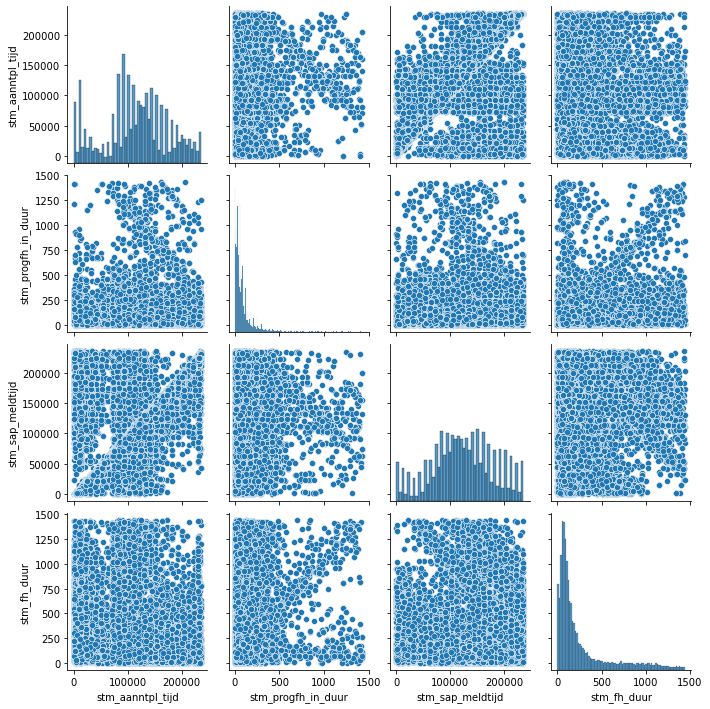

In [11]:
sb.pairplot(disruptions)

We zien hier niet echt sterke verbanden, er zijn wel wat patronen te zien, maar de data is toch veel verspreid.

# Baseline

De baseline is een simpel model dat constant het gemiddelde voorspelt, deze worden gebruikt om het model en de voorspellingen van de monteurs te verifiëren.

In [11]:
disruptions['baseline'] = disruptions['stm_fh_duur']
gem =  sum(disruptions['baseline'])/ len(disruptions['baseline'])
disruptions['baseline'] = disruptions['baseline'].apply(lambda x : gem)
disruptions['baseline'] = disruptions['baseline'].astype(int)
print(f"RSME: {np.sqrt(mean_squared_error(disruptions['stm_fh_duur'].astype(int), disruptions['baseline']))}")

RSME: 325.5889797221691


De RMSE is 325, dit is de score die verbeterd moet worden.

# Voorspellingen van de monteurs

Hieronder wroden de voorspellingen van de monteurs geplot tegen de daadwerkelijke duur.

<AxesSubplot:xlabel='stm_progfh_in_duur', ylabel='stm_fh_duur'>

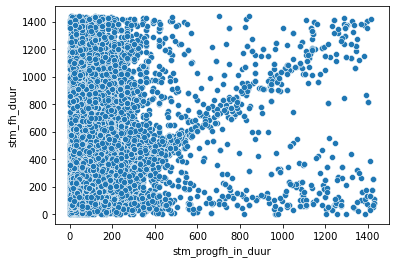

In [12]:
sb.scatterplot(y=disruptions['stm_fh_duur'], x=disruptions['stm_progfh_in_duur'])

We zien dat de monteurs niet heel accuraat voorspellen. Als de monteurs perfect zouden voorspellen zouden we een diagonale lijn zien. We zien dit een beetje, maar er is ook veel ruis aanwezig. Ten slotte berekenen we nog de RSME om te kijken hoe deze zich verhoudt met die van de monteurs.

In [13]:
print(f"RSME: {np.sqrt(mean_squared_error(disruptions['stm_fh_duur'].astype(int), disruptions['stm_progfh_in_duur']))}")

RSME: 361.74595755207895


We zien dat de RMSE hoger is dan die van het gemiddelde! Dat betekent dat de monteurs slechter zijn in het voorspellen dan onze baseline.

# Model

## De variabelen voorbereiden

Om een model te maken moeten we eerst de x en de y bepalen. De x waarden zijn bepaald door trail-and-error.

In [14]:
x = disruptions[['stm_sap_meldtijd', 'stm_aanntpl_tijd']]
y = disruptions['stm_fh_duur'].astype('int')

Daarna worden deze opgesplitst in een train en een test set.

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y)

Nu we onze data goed hebben voorbereid, kunnen er modellen mee getraind worden. 
Allereerst trainen we een DecisionTreeClassifier, en bepalen we de score.

## Decision tree classifier

In [16]:
dtc = DecisionTreeClassifier(max_depth = 50)
dtc.fit(X_train, Y_train)
score = dtc.score(X_test, Y_test)
y_pred = dtc.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
print(f"Accuracy score: {score}\nRMSE : {rmse}")

Accuracy score: 0.3256578947368421
RMSE : 156.1622572860885


We zien hier dat de score 0.32 is, en de RMSE 155. Nog niet echt een super resultaat, maar het is wel beter als zowel de baseline, als de voorspellingen van de monteurs.

De max_depth is bepaald met het onderstaande script. We zijn hier geïnteresseerd in de waarde waar de curve afvlakt.

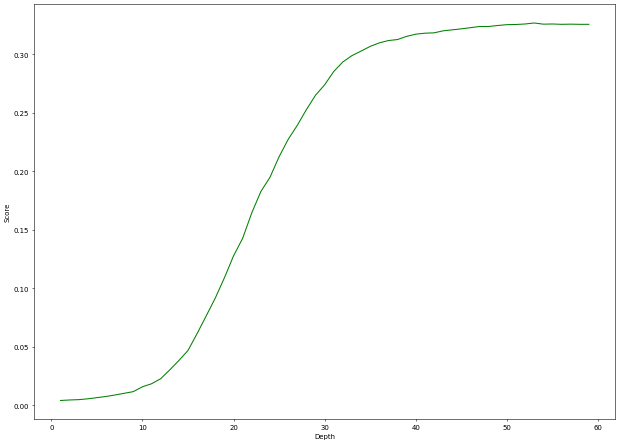

In [17]:
depths = []
scores = []

for depth in range(1, 60):
    dtc = DecisionTreeClassifier(max_depth= depth)
    dtc.fit(X_train, Y_train)
    y_pred = dtc.predict(X_test)    
    depths.append(depth)
    scores.append(accuracy_score(Y_test, y_pred))   

plt.figure(figsize=(15,11), dpi=50)
plt.plot(depths, scores, color="g")
plt.xlabel("Depth")
plt.ylabel("Score")
plt.show()

Hieronder tonen we de boom, zodat we (visueel) kunnen zien of de boom niet overfitted is. 

In [ ]:
plt.figure(figsize=(15,11), dpi=100)

tree.plot_tree(dtc, rounded=True, filled=True)

plt.show()

Omdat het plotten van deze boom erg lang duurt, en de notebook had besloten zichzelf te resetten tot een uur geleden, moeten we helaas een afbeelding gebruiken:

![boom](tree.png "Boom").

Omdat de score hoger kan, maken we ook nog een random forest model.

In [25]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, Y_test)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
print(f"Accuracy score: {score}\nRMSE : {rmse}")

Accuracy score: 0.33338100686498856
RMSE : 134.12871221944837


We zien dat de score met één procent omhoog is gegaan, en de RSME omlaag. Maar niet zo aanzienlijk dat het model er bruikbaarder door wordt.

## K nearest neighbours model

Nu trainen we ook een KNN model. Dit doen we ten eerste om te kijken welk model beter scoort, maar ook als een controle of ons eerste model niet overfit is.

In [24]:
knc = KNeighborsClassifier(n_neighbors = 40, weights="distance")
knc.fit(X_train, Y_train)
score = knc.score(X_test, Y_test)
y_pred = knc.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
print(f"Accuracy score: {score}\nRMSE : {rmse}")

Accuracy score: 0.3306636155606407
RMSE : 120.23410552575731


We zien dat de accuracy score, en de RMSE ongeveer even hoog zijn.

Hieronder staat het script dat berekent welke N waarde het beste scoort. Omdat N niet te laag mag zijn wegens risico op overfitting moet worden gekeken naar waar de grafiek het meeste afvlakt en niet naar de eerste piek.

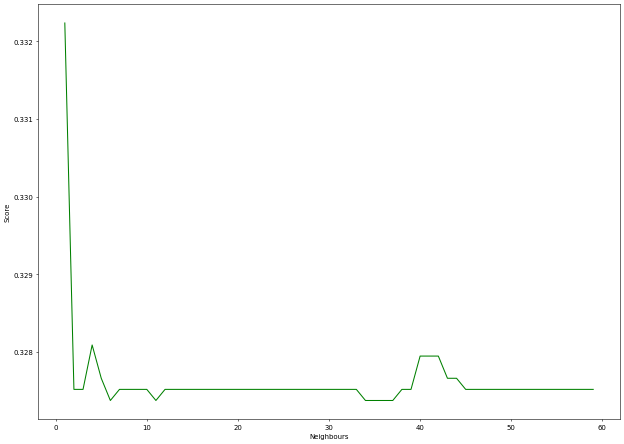

In [18]:
neighbours = []
scores = []
knc = KNeighborsClassifier()
knc.fit(X_train, Y_train)

for neighbour in range(1, 60):
    knc.set_params(n_neighbors = neighbour, weights="distance")
    y_pred = knc.predict(X_test)    
    neighbours.append(neighbour)
    scores.append(accuracy_score(Y_test, y_pred))   

plt.figure(figsize=(15,11), dpi=50)
plt.plot(neighbours, scores, color="g")
plt.xlabel("Neighbours")
plt.ylabel("Score")
plt.show()

Omdat het model uit 3 dimensies bestaat is het niet makkelijk deze te visualiseren.

## Lineaire regressie

Voordat er een lineaire regressie model kan worden gemaakt, moet er eerst worden gekeken naar de correlaties met de target variabele, stm_fh_duur. We zijn hier geïnteresseerd in de sterkste correlaties. (zowel negatief als positief)

In [19]:
all_columns = disruptions.columns.values
disruptions[all_columns].corr()['stm_fh_duur'].sort_values()

prio: 2              -0.375567
stm_aanntpl_tijd     -0.271526
prio: 9              -0.035709
prio: 8               0.009560
prio: 1               0.015186
stm_sap_meldtijd      0.082614
prio: 4               0.175678
prio: 5               0.252008
stm_progfh_in_duur    0.295188
stm_fh_duur           1.000000
baseline                   NaN
Name: stm_fh_duur, dtype: float64

Omdat we hier de sterkst correlerende waarden pakken, moeten we de train-test split opnieuw maken.

In [20]:
X=disruptions[['prio: 1', 'prio: 2' , 'prio: 4', 'prio: 5', 'stm_sap_meldtijd', 'stm_aanntpl_tijd', 'stm_progfh_in_duur']]
Y=disruptions['stm_fh_duur'].astype('int')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

Hierna trainen we weer het model.

In [21]:
lr = LinearRegression()
lr.fit(X_train,Y_train)
y_pred = lr.predict(X_test)
score = lr.score(X_test, Y_test)
rsme = np.sqrt(mean_squared_error(Y_test, y_pred))
print(f"Accuracy score: {score}\nRMSE : {rmse}")

Accuracy score: 0.3236145015495412
RMSE : 146.7080585163557


We zien wederom dat het model ongeveer even goed scoort als voorgaande modellen.

Naast een normale lineaire lijn kunnen we ook een polynoom trainen om te kijken of deze beter op de data aan sluit.

In [22]:
pf = PolynomialFeatures(degree = 3)
pf_ft = pf.fit_transform(X_test)
pf.fit(pf_ft,Y_test)
lr = LinearRegression()
lr.fit(pf_ft,Y_test)
score = lr.score(pf_ft, Y_test)
y_pred = lr.predict(pf.fit_transform(X_test))
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
print(f"Accuracy score: {score}\nRMSE : {rmse}")

Accuracy score: 0.6264667296676882
RMSE : 199.61905781472035


Nu zien we dat de accuracy score flink omhoog gaat. De RMSE is echter hoger.

Hieronder staat het script waarmee degree is bepaald, bij degrees hoger dan 3 is het programma eindeloos lang bezig, en daarom stopt deze hier.

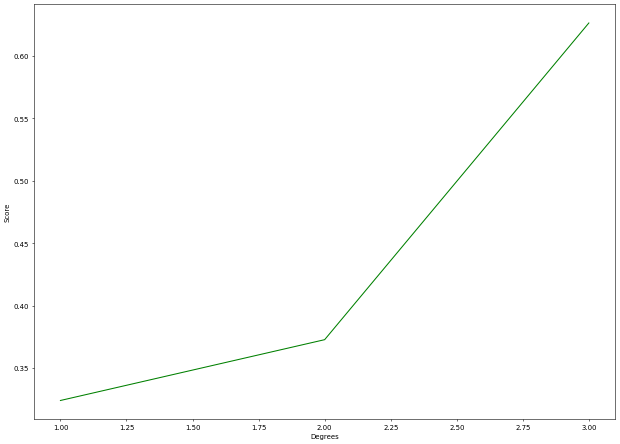

In [23]:
degrees = []
scores = []
for degree in range(1, 4):
    pf=PolynomialFeatures(degree = degree)
    pf_ft=pf.fit_transform(X_test)
    pf.fit(pf_ft,Y_test)
    lin_reg=LinearRegression()
    lin_reg.fit(pf_ft,Y_test) 
    degrees.append(degree)
    scores.append(lin_reg.score(pf_ft, Y_test))   
plt.figure(figsize=(15,11), dpi=50)
plt.plot(degrees, scores, color="g")
plt.xlabel("Degrees")
plt.ylabel("Score")
plt.show()

Omdat de polynoom 8-dimensionaal is, is het onmogelijk deze te plotten.

# Bijlage 

# Inladen volledige dataset

Hieronder staan de codefragmenten die lijden tot clean.csv.

In [ ]:
data = pd.read_csv("sap_storing_data_hu_project.csv")
disruptions = pd.DataFrame(data=data, index=data.index, columns=['stm_oorz_groep', 'stm_oorz_code','stm_geo_gst', 'stm_fh_ddt',
                                                               'stm_sap_storeind_ddt', 'stm_sap_melddatum', 'stm_sap_meldtijd',
                                                               'stm_aanntpl_tijd', 'stm_fh_dd', 'stm_fh_tijd', 'stm_fh_duur',
                                                               'stm_sap_storeinddatum', 'stm_sap_storeindtijd',
                                                               'stm_prioriteit', 'stm_progfh_in_duur'])
disruptions = disruptions.drop_duplicates()

In [ ]:
disruptions = pd.DataFrame(data=disruptions, index=disruptions.index, columns=['stm_prioriteit', 'stm_aanntpl_tijd', 'stm_progfh_in_duur',
                                                               'stm_sap_meldtijd', 'stm_fh_duur'])
disruptions = disruptions.iloc[1: , :]
disruptions = disruptions.convert_dtypes()

In [ ]:
disruptions.to_csv(path_or_buf='clean.csv', index=False)

# Data cleanup - unused

Hieronder wordt een nieuwe code aangemaakt voor onbekende stm_ooz_codes, 0.

In [ ]:
disruptions['stm_oorz_code'] = disruptions['stm_oorz_code'].astype(str)
disruptions['stm_oorz_code'] = disruptions['stm_oorz_code'].str.replace('<NA>', '0')
disruptions['stm_oorz_code'] = disruptions['stm_oorz_code'].fillna('0')
disruptions['stm_oorz_code'] = disruptions['stm_oorz_code'].astype(int)

Hieronder worden alle stm_geo_gst die niet numeriek zijn, verwijderd, zodat deze hele kolom kan worden omgezet tot een int. Hierdoor kan het model hiermee kan werken.

In [ ]:
disruptions =  disruptions[disruptions.stm_geo_gst.astype(str).apply(lambda x: x.isnumeric())]
disruptions["stm_geo_gst"] = disruptions["stm_geo_gst"].astype(int)

Hier wordt, zoals eerder in het verslag, de datum/tijd omgezet tot een voor het model leesbaar getal.

In [ ]:
disruptions["stm_sap_melddatum"] = pd.to_datetime(disruptions["stm_sap_melddatum"])
disruptions["stm_sap_melddatum"] = disruptions["stm_sap_melddatum"].dropna().apply(lambda a: int(a.strftime('%Y%m%d')))
disruptions["stm_sap_melddatum"] = disruptions["stm_sap_melddatum"].astype(int)

In [ ]:
disruptions["stm_aanntpl_dd"] = disruptions["stm_aanntpl_dd"].str.replace("/", "")
disruptions = disruptions[disruptions.stm_aanntpl_dd != '']
disruptions["stm_aanntpl_dd"] = disruptions["stm_aanntpl_dd"].dropna()
disruptions["stm_aanntpl_dd"] = disruptions["stm_aanntpl_dd"].astype(int)

In [ ]:
disruptions["stm_aanngeb_dd"] = disruptions["stm_aanngeb_dd"].str.replace("/", "")
disruptions = disruptions[disruptions.stm_aanngeb_dd != '']
disruptions["stm_aanngeb_dd"] = disruptions["stm_aanngeb_dd"].dropna()
disruptions["stm_aanngeb_dd"] = disruptions["stm_aanngeb_dd"].astype(int)

In [ ]:
disruptions["stm_aanngeb_tijd"] = disruptions["stm_aanngeb_tijd"].str.replace(":", "")
disruptions = disruptions[disruptions.stm_aanngeb_tijd != '']
disruptions["stm_aanngeb_tijd"] = disruptions["stm_aanngeb_tijd"].dropna()
disruptions["stm_aanngeb_tijd"] = disruptions["stm_aanngeb_tijd"].astype(int)

Hieronder worden dummies aangemaakt voor stm_oporzaak_groep.

In [ ]:
dummies = pd.get_dummies(disruptions['stm_oorz_groep'])
disruptions = disruptions.drop('stm_oorz_groep',axis = 1)
disruptions = disruptions.join(dummies)

Hieronder worden stm_sap_meldtijd en stm_sap_meld_ddt samengevoegd tot één datetime object.

In [ ]:
disruptions['stm_sap_meldtijd'] = disruptions['stm_sap_meldtijd'].str.replace("::", "00:00:00")
disruptions['stm_sap_meld_ddt'] = pd.to_datetime(disruptions.stm_sap_melddatum[disruptions.stm_sap_melddatum != '00000000'].dropna().astype(str) + ' ' + disruptions.stm_sap_meldtijd[disruptions.stm_sap_meldtijd != '00:00:00'].dropna().astype(str))